## mQTL summary

Summary of mQTLs across all metabolites

In [1]:
.libPaths("~/R/x86_64-redhat-linux-gnu-library/3.2/")
# config opts and libraries
options(repr.plot.width = 6)
options(repr.plot.height = 5)
options(jupyter.plot_mimetypes = 'image/png')
library(ggplot2);
library(plyr);
library(dplyr);
library(reshape2);
library(LSD);
library(qtl);
library(pheatmap);
library(funqtl);
library(parallel);
options(mc.cores = 24);
library(snow);
library(igraph);
library(stringr);
library(RColorBrewer);
library(jpeg);
library(pheatmap);
library(GenomicRanges);
library(zoo);


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
: package ‘qtl’ was built under R version 3.2.3Loading required package: fields
Loading required package: spam
Loading required package: grid
Spam version 1.3-0 (2015-10-24) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: ‘spam’

The following objects are masked from ‘package:base’:

    backsolve, forwardsolve

Loading required package: maps

 # maps v3.1: updated 'world': all lakes moved to separate new #
 # 'lakes' database. Type '?world' or '

In [2]:
# load data
endo_f = "/g/steinmetz/project/GenPhen/data/endometabolome/data/endometabolite_full_12102015.rda"
load(endo_f)

# use only relaitve data
endometabolite = filter(endometabolite, time_format == "relative")

#head(endometabolite)

In [3]:
# load normalized QTLs
load("/g/steinmetz/brooks/genphen//metabolome/qtls/mQTLs_comball_funqtl_2014.rda")
mQTLs_funqtl_2014_class = sapply(mQTLs_funqtl_2014,class)
mQTLs_funqtl_2014 = mQTLs_funqtl_2014[mQTLs_funqtl_2014_class!="try-error"]

Combine all mlod socres together

In [4]:
mqtls = do.call(rbind,lapply(seq(1,length(mQTLs_funqtl_2014)), function(i){
    metabolite = names(mQTLs_funqtl_2014)[i]
    d = data.frame(mQTLs_funqtl_2014[[i]]$qtls_alt)
    # e matrix sets the direction of effect
    e = data.frame(mQTLs_funqtl_2014[[i]]$eff)
    e = apply(e, 1, median)
    ee = rollapply(as.numeric(e/abs(e)), width = 100, by = 75, FUN = median)
    d = d %>% select(chr, pos, mlod)
    # downsample
    dd = apply(d, 2, function(x) rollapply(as.numeric(x), width = 100, by = 75, FUN = median))
    o = data.frame(metabolite,dd)
    o$mlod = o$mlod * ee
    return(o)
}))

In [5]:
mqtl_m = acast(mqtls, chr+pos~metabolite, value.var = "mlod")

In [6]:
annotations = data.frame(Chr = factor(sapply(rownames(mqtl_m), function(i){strsplit(i,"_")[[1]][1]}), 
                                      levels = seq(1,16)))

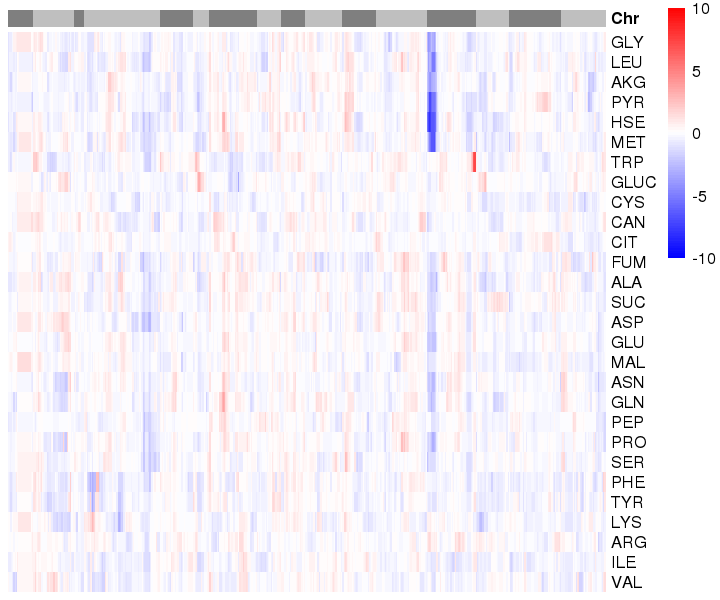

In [7]:
ac = rep(c("grey50","grey75"),length(levels(annotations$Chr))/2)
names(ac) = levels(annotations$Chr)
annotation_colors = list(Chr = ac)
colorder = hclust(dist(t(mqtl_m)))

pheatmap(t(mqtl_m)[colorder$order,], cluster_cols = F, cluster_rows = F, treeheight_row = 0, show_colnames = F, 
         breaks = seq(-10,10,length.out = 100), color = colorRampPalette(c("blue","white","red"))(100),
        annotation = annotations, annotation_legend = F, annotation_color = annotation_colors)



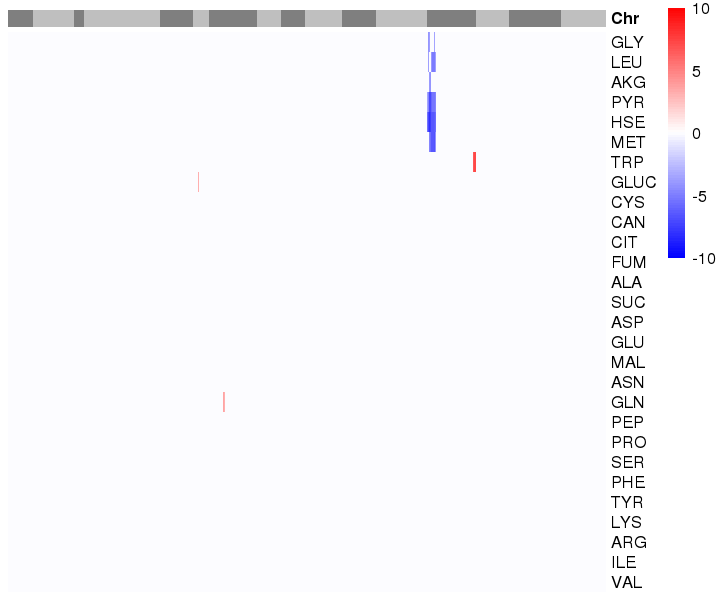

In [8]:
ac = rep(c("grey50","grey75"),length(levels(annotations$Chr))/2)
names(ac) = levels(annotations$Chr)
annotation_colors = list(Chr = ac)
tmp_m = mqtl_m
tmp_m[tmp_m <= 3.3 & tmp_m >= -3.3] = 0

pheatmap(t(tmp_m)[colorder$order,], cluster_rows = F, cluster_cols = F, treeheight_row = 0, show_colnames = F, 
         breaks = seq(-10,10,length.out = 100), color = colorRampPalette(c("blue","white","red"))(100),
        annotation = annotations, annotation_legend = F, annotation_color = annotation_colors)